In [88]:
import pandas as pd

from core.fs import FsLoader
from core.repository.maria.conn import maria_home
from utils.timeutil import YearMonth
from utils.timeutil import YearQtr

begin = YearMonth(2014, 4)
end = YearMonth(2023, 10)

# 월 차트 로드
print("Fetching month chart...")
month_chart = pd.read_sql(
    f"""
    select month_chart.*, stocks.stock_name as name from month_chart
    join stocks on month_chart.code = stocks.stock_code
    """,
    maria_home()
)

# 재무제표 로드
print("Loading financial data...")
fs_loader = FsLoader()

month_chart["년월"] = [YearMonth.from_date(d) for d in month_chart["date"]]
layer1 = pd.DataFrame()
yms = list(begin.to(end))
yms = pd.Series(yms)
yms = yms.drop_duplicates().sort_values()

print("Making layer1...")
for ym1, ym2 in [(ym.iloc[0], ym.iloc[1]) for ym in yms.rolling(2) if len(ym) == 2]:
    print(f"\r{ym1} {ym2}", end="\r")
    df1 = month_chart[month_chart["년월"] == ym1].set_index("code")
    df2 = month_chart[month_chart["년월"] == ym2].set_index("code")
    df1 = df1[df1["open"] > 0]  # 시가=0 은 거래정지
    df1 = df1[df1["val_last"] > 1_0000_0000]  # 거래량 1억 이상(거래량 적을 시 매수 실패할거라고 가정)

    df2["close"] = df2["close"].astype(float)
    df2.loc[(df2["open"] == 0) | (df2["val_last"] == 0), "close"] /= 2  # 거래정지 시 투자금이 1/2 된다고 가정

    df = pd.DataFrame({
        "매수년월": ym1,
        "매도년월": ym2,
        "종목명": df1["name"],
        "매수일": df1["date"],
        "매수가": df1["close"],
        "시가총액": df1["cap"],
        "거래량": df1["vol"],
        "거래대금": df1["val"],
        "전월수익률": df1["close"] / df1["open"] - 1,
        "val": df1["val"],
        "val_last": df1["val_last"],
        "매도가": df2["close"],
        "매도일": df2["date"]
    }).reindex(df1.index)

    shares = pd.concat([df1["shares"], df2["shares"]], axis=1)
    df = df.loc[shares.max(axis=1) / shares.min(axis=1) < 1.5]  # 액면분할 제거
    df.loc[df["매도가"].isna(), "매도가"] = 0
    df["수익률"] = df["매도가"] / df["매수가"] - 1
    
    settled_qtr = YearQtr.settled_of(ym1.last_date)
    fn = fs_loader.load(settled_qtr.year, settled_qtr.qtr)
    layer1 = pd.concat([layer1, df.join(fn)])

layer1.reset_index(inplace=True)
layer1.to_csv(".analysis/layer1.csv", index=False)

Fetching month chart...
Loading financial data...
Making layer1...


In [89]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
from utils.timeutil import YearMonth

if os.path.exists(".analysis/layer1.csv"):
    layer1 = pd.read_csv(".analysis/layer1.csv")
    layer1["매수년월"] = layer1["매수년월"].apply(lambda x: YearMonth.from_string(x))
    layer1["매도년월"] = layer1["매도년월"].apply(lambda x: YearMonth.from_string(x))

font_path = './res/font/Gothic_A1/GothicA1-Medium.ttf'
font_manager.fontManager.addfont(font_path)
font_name = font_manager.fontManager.ttflist[-1].name

plt.rc("font", family=font_name)
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)
plt.rcParams['agg.path.chunksize'] = 10_000

layer1

,code,매수년월,매도년월,종목명,매수일,매수가,시가총액,거래량,거래대금,전월수익률,...,O_QoQ,E_QoQ,R/A_QoQ,R/EQ_QoQ,GP/A_QoQ,GP/EQ_QoQ,O/A_QoQ,O/EQ_QoQ,E/A_QoQ,E/EQ_QoQ
0,53330,2014-04,2014-05,영진코퍼레이션,2014-04-30,880.0,1.862769e+10,15777003.0,1.680384e+10,0.045131,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3640,2014-04,2014-05,유니온스틸,2014-04-30,14100.0,1.446660e+11,129768.0,1.908398e+09,-0.056856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,950130,2014-04,2014-05,엑세스바이오,2014-04-30,11000.0,2.982540e+11,11140311.0,1.219060e+11,0.023256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,68870,2014-04,2014-05,LG생명과학,2014-04-30,35750.0,5.926274e+11,2745885.0,1.013983e+11,-0.064136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,86830,2014-04,2014-05,신양오라컴디스플레이,2014-04-30,3295.0,2.313090e+10,1654819.0,5.322223e+09,0.069805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200916,42670,2023-09,2023-10,HD현대인프라코어,2023-09-27,10600.0,2.115797e+12,52378927.0,5.715041e+11,0.006648,...,2.631597,2.922384,0.296806,0.663152,0.083920,0.196821,0.047602,0.117552,0.035074,0.087296
200917,54620,2023-09,2023-10,APS,2023-09-27,7710.0,1.572394e+11,1512733.0,1.225333e+10,-0.079952,...,-2.157330,-0.941337,0.018448,0.028930,0.002777,0.003343,-0.025004,-0.040962,-0.015548,-0.028815
200918,238500,2023-09,2023-10,로보쓰리에이아이앤로보틱스,2023-09-27,936.0,2.013819e+10,5678047.0,4.715497e+09,0.485714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200919,424980,2023-09,2023-10,마이크로투나노,2023-09-27,16300.0,9.647791e+10,1606473.0,3.070538e+10,-0.128342,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
import numpy as np

layer2 = layer1.rename(
    columns={
        "시가총액": "P",
        "거래대금": "TV",
    }
)

factors = [col for col in layer1.columns if "QoQ" in col and "QoQA" not in col]
factors += ["P"]

layer2["EQ/P"] = layer2["EQ"] / layer2["P"]
layer2["R/P"] = layer2["R/Y"] / layer2["P"]
layer2["GP/P"] = layer2["GP/Y"] / layer2["P"]
layer2["O/P"] = layer2["O/Y"] / layer2["P"]
layer2["E/P"] = layer2["E/Y"] / layer2["P"]
factors += ["EQ/P", "R/P", "GP/P", "O/P", "E/P"]

layer2["R/A"] = layer2["R/Y"] / layer2["A"]
layer2["GP/A"] = layer2["GP/Y"] / layer2["A"]
layer2["O/A"] = layer2["O/Y"] / layer2["A"]
layer2["E/A"] = layer2["E/Y"] / layer2["A"]
factors += ["R/A", "GP/A", "O/A", "E/A"]

layer2["R/EQ"] = layer2["R/Y"] / layer2["EQ"]
layer2["GP/EQ"] = layer2["GP/Y"] / layer2["EQ"]
layer2["O/EQ"] = layer2["O/Y"] / layer2["EQ"]
layer2["E/EQ"] = layer2["E/Y"] / layer2["EQ"]
factors += ["R/EQ", "GP/EQ", "O/EQ", "E/EQ"]

layer2["GP/A/P"] = layer2["GP/Y"] / layer2["A"] / layer2["P"]
factors += ["GP/A/P"]

layer2["GPGP/A"] = layer2["GP/Y"] ** 2 / layer2["A"]
factors += ["GPGP/A"]

layer2["GPGP/A/P"] = layer2["GP/Y"] ** 2 / layer2["A"] / layer2["P"]
factors += ["GPGP/A/P"]

recipes = {
    "개사기": {
        "GP/A/P": 1,
        "P": -1
    },
    "벨류": {
        "EQ/P": 1,
        "GP/P": 1,
    },
    "성장": {
        "GP/A_QoQ": 0.142706,
        "O/A_QoQ": 0.130182,
        "GP/EQ_QoQ": 0.129825,
        "O/EQ_QoQ": 0.118514,
        "E/EQ_QoQ": 0.111300,
        "O_QoQ": 0.098340,
        "E_QoQ": 0.097314,
        "GP_QoQ": 0.083276,
        "R/A_QoQ": 0.082624,
        "E/A_QoQ": 0.079270,
        "R/EQ_QoQ": 0.028347,
        "R_QoQ": 0.022196,
    },
    "전략": {
        "P": -1,
        "벨류": 1,
        "성장": 1,
    },
}

result = pd.DataFrame()
yms = layer2["매도년월"].drop_duplicates().sort_values()
for ym in yms:
    print(f"\r{ym}", end="")
    df = layer2[layer2["매도년월"] == ym].copy()
    for factor in factors:
        df[f"{factor}_pct"] = np.ceil(df[factor].rank(pct=True) * 100)

    for title, recipe in recipes.items():
        # df[title] = pd.concat(
        #     [(df[f"{k}_pct"] if w > 0 else 1 / df[f"{k}"]) ** abs(w) for k, w in recipe.items()],
        #     axis=1
        # ).prod(axis=1, skipna=False)
        df[title] = sum([df[f"{k}_pct"] * w for k, w in recipe.items()])
        df[f"{title}_pct"] = np.ceil(df[title].rank(pct=True) * 100)

    result = pd.concat([result, df])

result

2023-10

,code,매수년월,매도년월,종목명,매수일,매수가,P,거래량,TV,전월수익률,...,GPGP/A_pct,GPGP/A/P_pct,개사기,개사기_pct,벨류,벨류_pct,성장,성장_pct,전략,전략_pct
0,53330,2014-04,2014-05,영진코퍼레이션,2014-04-30,880.0,1.862769e+10,15777003.0,1.680384e+10,0.045131,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3640,2014-04,2014-05,유니온스틸,2014-04-30,14100.0,1.446660e+11,129768.0,1.908398e+09,-0.056856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,950130,2014-04,2014-05,엑세스바이오,2014-04-30,11000.0,2.982540e+11,11140311.0,1.219060e+11,0.023256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,68870,2014-04,2014-05,LG생명과학,2014-04-30,35750.0,5.926274e+11,2745885.0,1.013983e+11,-0.064136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,86830,2014-04,2014-05,신양오라컴디스플레이,2014-04-30,3295.0,2.313090e+10,1654819.0,5.322223e+09,0.069805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200916,42670,2023-09,2023-10,HD현대인프라코어,2023-09-27,10600.0,2.115797e+12,52378927.0,5.715041e+11,0.006648,...,96.0,83.0,-76.0,10.0,131.0,68.0,101.763457,98.0,73.0,64.0
200917,54620,2023-09,2023-10,APS,2023-09-27,7710.0,1.572394e+11,1512733.0,1.225333e+10,-0.079952,...,17.0,16.0,-22.0,38.0,96.0,48.0,26.868257,17.0,17.0,29.0
200918,238500,2023-09,2023-10,로보쓰리에이아이앤로보틱스,2023-09-27,936.0,2.013819e+10,5678047.0,4.715497e+09,0.485714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200919,424980,2023-09,2023-10,마이크로투나노,2023-09-27,16300.0,9.647791e+10,1606473.0,3.070538e+10,-0.128342,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[4/4] 전략기2014-04 2023-10
           개사기   벨류        성장   전략
GP/A/P     1.0  NaN       NaN  NaN
P         -1.0  NaN       NaN -1.0
EQ/P       NaN  1.0       NaN  NaN
GP/P       NaN  1.0       NaN  NaN
GP/A_QoQ   NaN  NaN  0.142706  NaN
O/A_QoQ    NaN  NaN  0.130182  NaN
GP/EQ_QoQ  NaN  NaN  0.129825  NaN
O/EQ_QoQ   NaN  NaN  0.118514  NaN
E/EQ_QoQ   NaN  NaN  0.111300  NaN
O_QoQ      NaN  NaN  0.098340  NaN
E_QoQ      NaN  NaN  0.097314  NaN
GP_QoQ     NaN  NaN  0.083276  NaN
R/A_QoQ    NaN  NaN  0.082624  NaN
E/A_QoQ    NaN  NaN  0.079270  NaN
R/EQ_QoQ   NaN  NaN  0.028347  NaN
R_QoQ      NaN  NaN  0.022196  NaN
벨류         NaN  NaN       NaN  1.0
성장         NaN  NaN       NaN  1.0


,spearman,kendall,h5,h10,t5,t10,mdd5,h10-t10,mean,median,strength
전략,0.895254,0.723636,0.285116,0.265767,-0.136224,-0.098979,-0.319369,0.364746,0.046886,0.029077,0.326540
개사기,0.777414,0.595960,0.378702,0.309959,-0.020402,-0.031848,-0.305317,0.341807,0.051017,0.005747,0.265725
벨류,0.721512,0.526061,0.104063,0.120058,-0.101118,-0.082705,-0.462221,0.202763,0.043821,0.043944,0.146296
성장,0.721488,0.526061,0.137436,0.137875,-0.034784,-0.018062,-0.421550,0.155937,0.046663,0.037410,0.112506


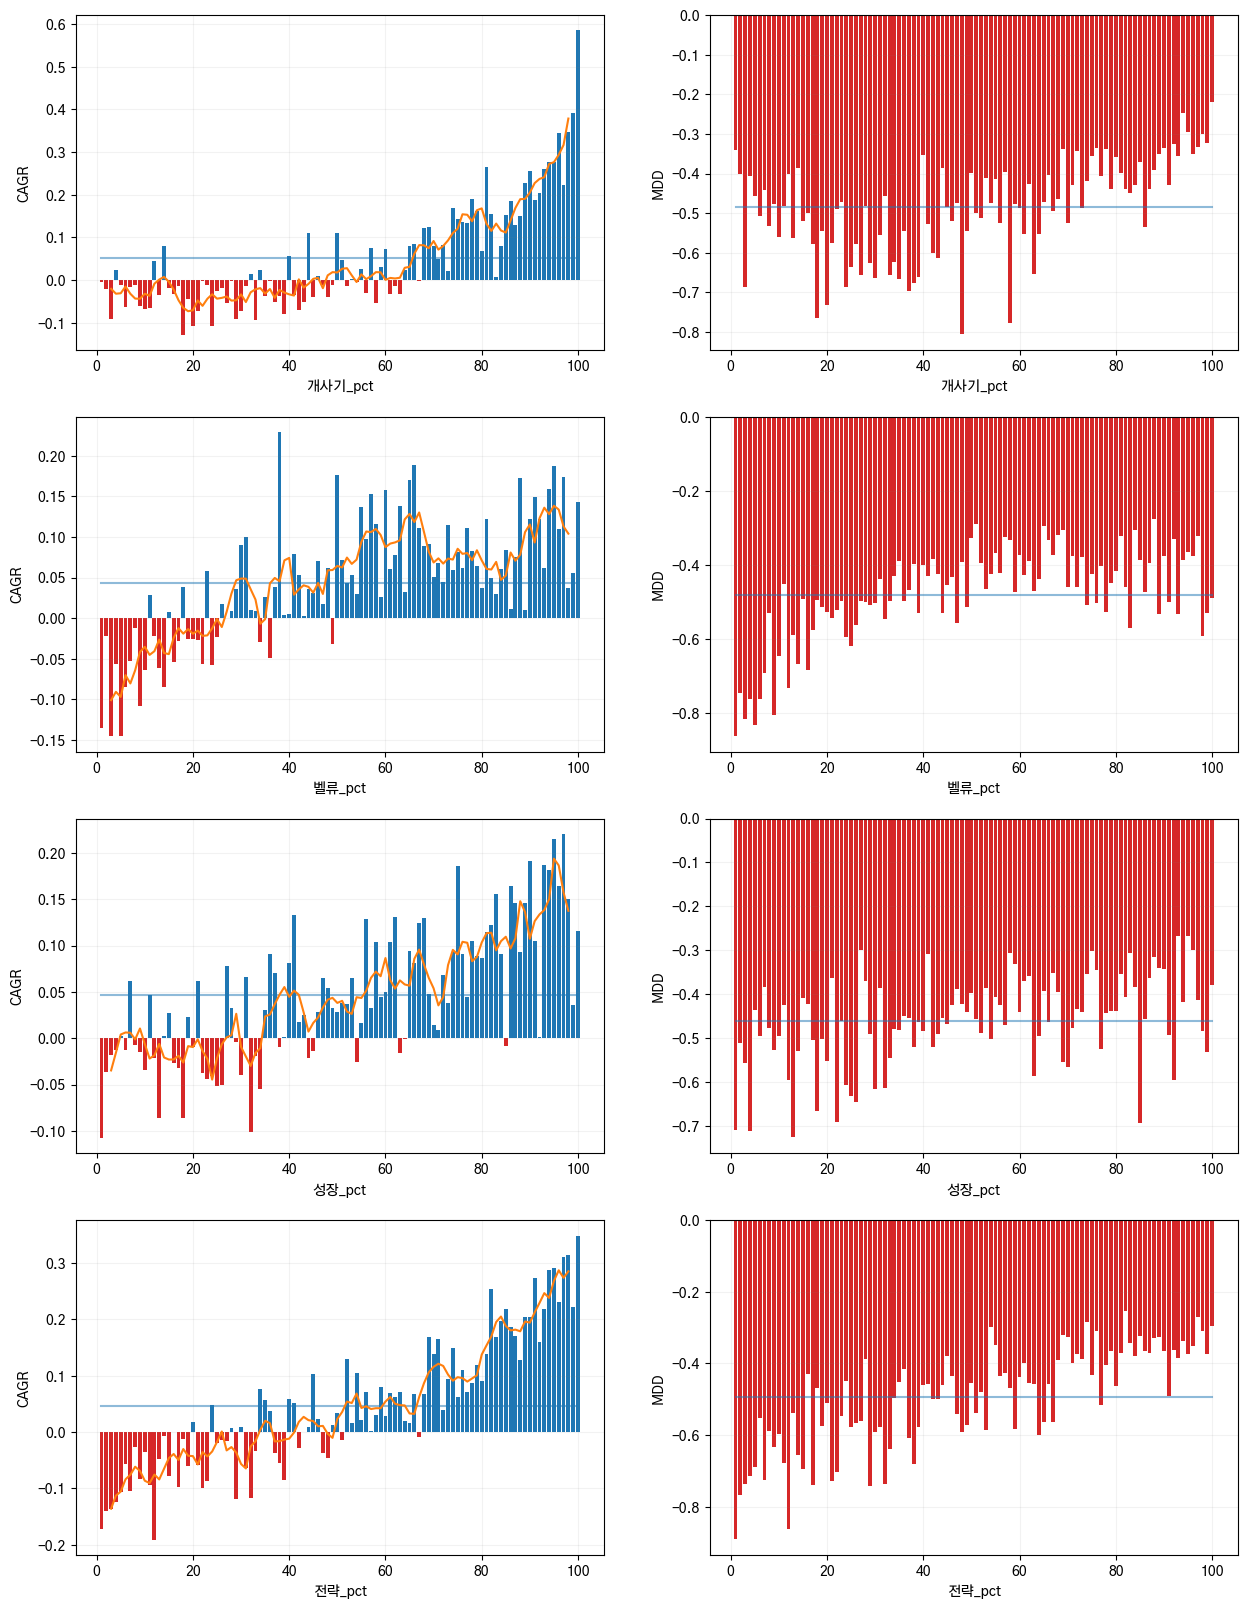

In [91]:
import matplotlib.pyplot as plt
from utils.quantutil import cagr, mdd

target_factors = list(recipes.keys())
fig, subplots = plt.subplots(len(target_factors), 2)
fig.set_figwidth(15), fig.set_figheight(5 * len(target_factors))
summary = pd.DataFrame()
for i in range(len(target_factors)):
    factor = target_factors[i]
    print(f"\r[{i + 1}/{len(target_factors)}] {factor}", end="")
    colname = f"{factor}_pct"
    pcts = result[colname].dropna().sort_values().unique()
    mean_by_pct = []
    cagr_by_pct = []
    mdd_by_pct = []
    for pct in pcts:
        by_pct = result[result[colname] == pct]
        return_by_ym = by_pct.groupby("매도년월")["수익률"].mean()
        cumprod = (return_by_ym + 1).cumprod()
        mean_by_pct.append(return_by_ym.mean())
        cagr_by_pct.append(cagr(1, cumprod.iloc[-1], by_pct["매수년월"].min().duration(by_pct["매도년월"].max())))
        dates = [s.last_date for s in return_by_ym.index]
        mdd_by_pct.append(mdd(dates, cumprod.values)[0])

    ax1, ax2 = subplots[i][0], subplots[i][1]
    cagr_by_pct, mdd_by_pct = pd.Series(cagr_by_pct), pd.Series(mdd_by_pct)

    ax1.set_xlabel(colname)
    ax1.set_ylabel("CAGR")
    ax1.grid(True)
    ax1.bar(pd.Series(pcts), cagr_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in cagr_by_pct])
    ax1.plot(pd.Series(pcts), [cagr_by_pct.mean() for _ in pd.Series(pcts)], alpha=0.5)
    ax1.plot(pd.Series(pcts), cagr_by_pct.rolling(5, center=True).mean())

    ax2.set_xlabel(colname)
    ax2.set_ylabel("MDD")
    ax2.grid(True)
    ax2.bar(pd.Series(pcts), mdd_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in mdd_by_pct])
    ax2.plot(pd.Series(pcts), [mdd_by_pct.mean() for _ in pd.Series(pcts)], alpha=0.5)

    spearman = pd.DataFrame({colname: pcts, "CAGR": cagr_by_pct}).corr(method="spearman")
    kendall = pd.DataFrame({colname: pcts, "CAGR": cagr_by_pct}).corr(method="kendall")
    cagr_by_pct_desc = cagr_by_pct[cagr_by_pct.index.sort_values(ascending=False)]
    mdd_by_pct_desc = mdd_by_pct[mdd_by_pct.index.sort_values(ascending=False)]
    summary = pd.concat([
        summary,
        pd.Series({
            "spearman": spearman[colname]["CAGR"],
            "kendall": kendall[colname]["CAGR"],
            "h5": cagr_by_pct_desc.head(5).mean(),
            "h10": cagr_by_pct_desc.head(10).mean(),
            "t5": cagr_by_pct_desc.tail(5).mean(),
            "t10": cagr_by_pct_desc.tail(10).mean(),
            "mdd5": mdd_by_pct_desc.head(5).mean(),
            "h10-t10": cagr_by_pct_desc.head(10).mean() - cagr_by_pct_desc.tail(10).mean(),
            "mean": cagr_by_pct_desc.mean(),
            "median": cagr_by_pct_desc.median(),
        }).to_frame(factor).T
    ])
    summary["strength"] = summary["spearman"] * summary["h10-t10"]

print(result["매수년월"].min(), result["매도년월"].max())
print(pd.DataFrame(recipes))
summary = summary.sort_values(by="strength", ascending=False)
summary

In [92]:
# 백테스트: 매매 시뮬레이션

from utils.quantutil import cagr, mdd

_key = ["매수년월", "매도년월"]
benchmark = result.groupby(_key)["수익률"].mean()

factor = "전략"
print(factor)

result2 = result.copy()[result[factor].notna()]

result2 = result2[~result2["종목명"].str.endswith("홀딩스")]
result2 = result2[~result2["종목명"].str.endswith("지주")]
result2 = result2[result2["R/A_pct"] > 10]
result2 = result2[result2["GP/A_pct"] > 10]
result2 = result2[result2["O/A_pct"] > 10]
result2 = result2[result2["E/A_pct"] > 10]
result2 = result2[result2["R/EQ_pct"] > 10]
result2 = result2[result2["GP/EQ_pct"] > 10]
result2 = result2[result2["O/EQ_pct"] > 10]
result2 = result2[result2["E/EQ_pct"] > 10]

head = 20
strategy = result2.dropna().groupby(_key).apply(
    lambda x: x.sort_values(factor, ascending=False).head(head)["수익률"].mean())
strategy = pd.Series(strategy, index=benchmark.index).fillna(0)

revisions = pd.DataFrame({
    "벤치마크 수익률": benchmark,
    "전략 수익률": strategy,
    "성능": round(strategy - benchmark, 2),
    "벤치마크 누적수익률": (benchmark + 1).cumprod(),
    "전략 누적수익률": (strategy + 1).cumprod()
})

years = (end.value() - begin.value()) / 12

summary = pd.DataFrame({
    "CAGR": [cagr(1, revisions["전략 누적수익률"].iloc[-1], years), cagr(1, revisions["벤치마크 누적수익률"].iloc[-1], years)],
    "MDD": [mdd([i2 for _, i2 in revisions.index], revisions["전략 누적수익률"].tolist()),
            mdd([i2 for _, i2 in revisions.index], revisions["벤치마크 누적수익률"].tolist())],
    "Mean": [revisions["전략 수익률"].mean(), revisions["벤치마크 수익률"].mean()]
}, index=["전략", "벤치마크"])
print(summary)

result3 = result2.groupby(_key).apply(
    lambda x: x.sort_values(factor, ascending=False).head(head).sort_values("수익률", ascending=False))[
    ["code", "종목명", "수익률", "매수일", "매도일", "매수가", "매도가", "val_last", "P_pct", "성장_pct", "벨류_pct", f"{factor}_pct"]]
result3.to_csv(".analysis/result3.csv")
result3

전략
          CAGR                                         MDD      Mean
전략    0.368814  (-0.22388345295237233, (2018-05, 2018-10))  0.029813
벤치마크  0.029775  (-0.39749020543683156, (2018-05, 2020-03))  0.004336


code    종목명       수익률         매수일         매도일  \
매수년월    매도년월                                                              
2014-04 2014-05 858       5750  대림비앤코  0.157746  2014-04-30  2014-05-30   
                682      24940   PN풍년  0.103774  2014-04-30  2014-05-30   
                1104      3310   대주산업  0.029008  2014-04-30  2014-05-30   
                1018     14200     광림  0.028571  2014-04-30  2014-05-30   
                1134     96040    이트론  0.020134  2014-04-30  2014-05-30   
...                        ...    ...       ...         ...         ...   
2023-09 2023-10 200159   35460  기산텔레콤 -0.072125  2023-09-27  2023-10-27   
                199291   42940  상지카일룸 -0.083499  2023-09-27  2023-10-27   
                199149   19180  티에이치엔 -0.086538  2023-09-27  2023-10-27   
                199779    5320     국동 -0.099741  2023-09-27  2023-10-27   
                199014  900260    로스웰 -0.112440  2023-09-27  2023-10-27   

                           매수가     매도가      val_last  P_pct  성장_pct  벨류_pct  \
매수년월    매도년월                                                                  
2014-04 2014-05 858     3550.0  4110.0  2.780541e+08   20.0    78.0    93.0   
                682     2120.0  2340.0  1.257300e+08    3.0    93.0    92.0   
                1104     655.0   674.0  2.037087e+08    4.0    66.0    95.0   
                1018    1925.0  1980.0  1.499534e+09   11.0    97.0    87.0   
                1134     596.0   608.0  3.574902e+08    1.0    95.0    91.0   
...                        ...     ...           ...    ...     ...     ...   
2023-09 2023-10 200159  2565.0  2380.0  1.795514e+08    4.0    91.0    73.0   
                199291   503.0   461.0  1.724627e+08   10.0   100.0    86.0   
                199149  3120.0  2850.0  1.119061e+09   11.0    86.0    93.0   
                199779   772.0   695.0  2.437703e+08    7.0    75.0    94.0   
                199014   836.0   742.0  1.007658e+08    2.0    83.0    92.0   

                        전략_pct  
매수년월    매도년월                    
2014-04 2014-05 858       98.0  
                682      100.0  
                1104      99.0  
                1018     100.0  
                1134     100.0  
...                        ...  
2023-09 2023-10 200159    99.0  
                199291   100.0  
                199149   100.0  
                199779    99.0  
                199014   100.0  

[2280 rows x 12 columns]

In [93]:
revisions

,,벤치마크 수익률,전략 수익률,성능,벤치마크 누적수익률,전략 누적수익률
매수년월,매도년월,,,,,
2014-04,2014-05,-0.010339,-0.018714,-0.01,0.989661,0.981286
2014-05,2014-06,-0.013571,-0.000558,0.01,0.976230,0.980739
2014-06,2014-07,0.014194,0.012394,-0.00,0.990087,0.992894
2014-07,2014-08,0.039853,0.087988,0.05,1.029545,1.080256
2014-08,2014-09,0.005352,0.072055,0.07,1.035055,1.158094
...,...,...,...,...,...,...
2023-05,2023-06,0.006412,0.007116,0.00,1.563446,23.187074
2023-06,2023-07,-0.029541,-0.055140,-0.03,1.517259,21.908549
2023-07,2023-08,0.016191,-0.022496,-0.04,1.541825,21.415703


total          114.000000
out-perform     76.000000
승률               0.666667
누적 성능           15.566118
dtype: float64

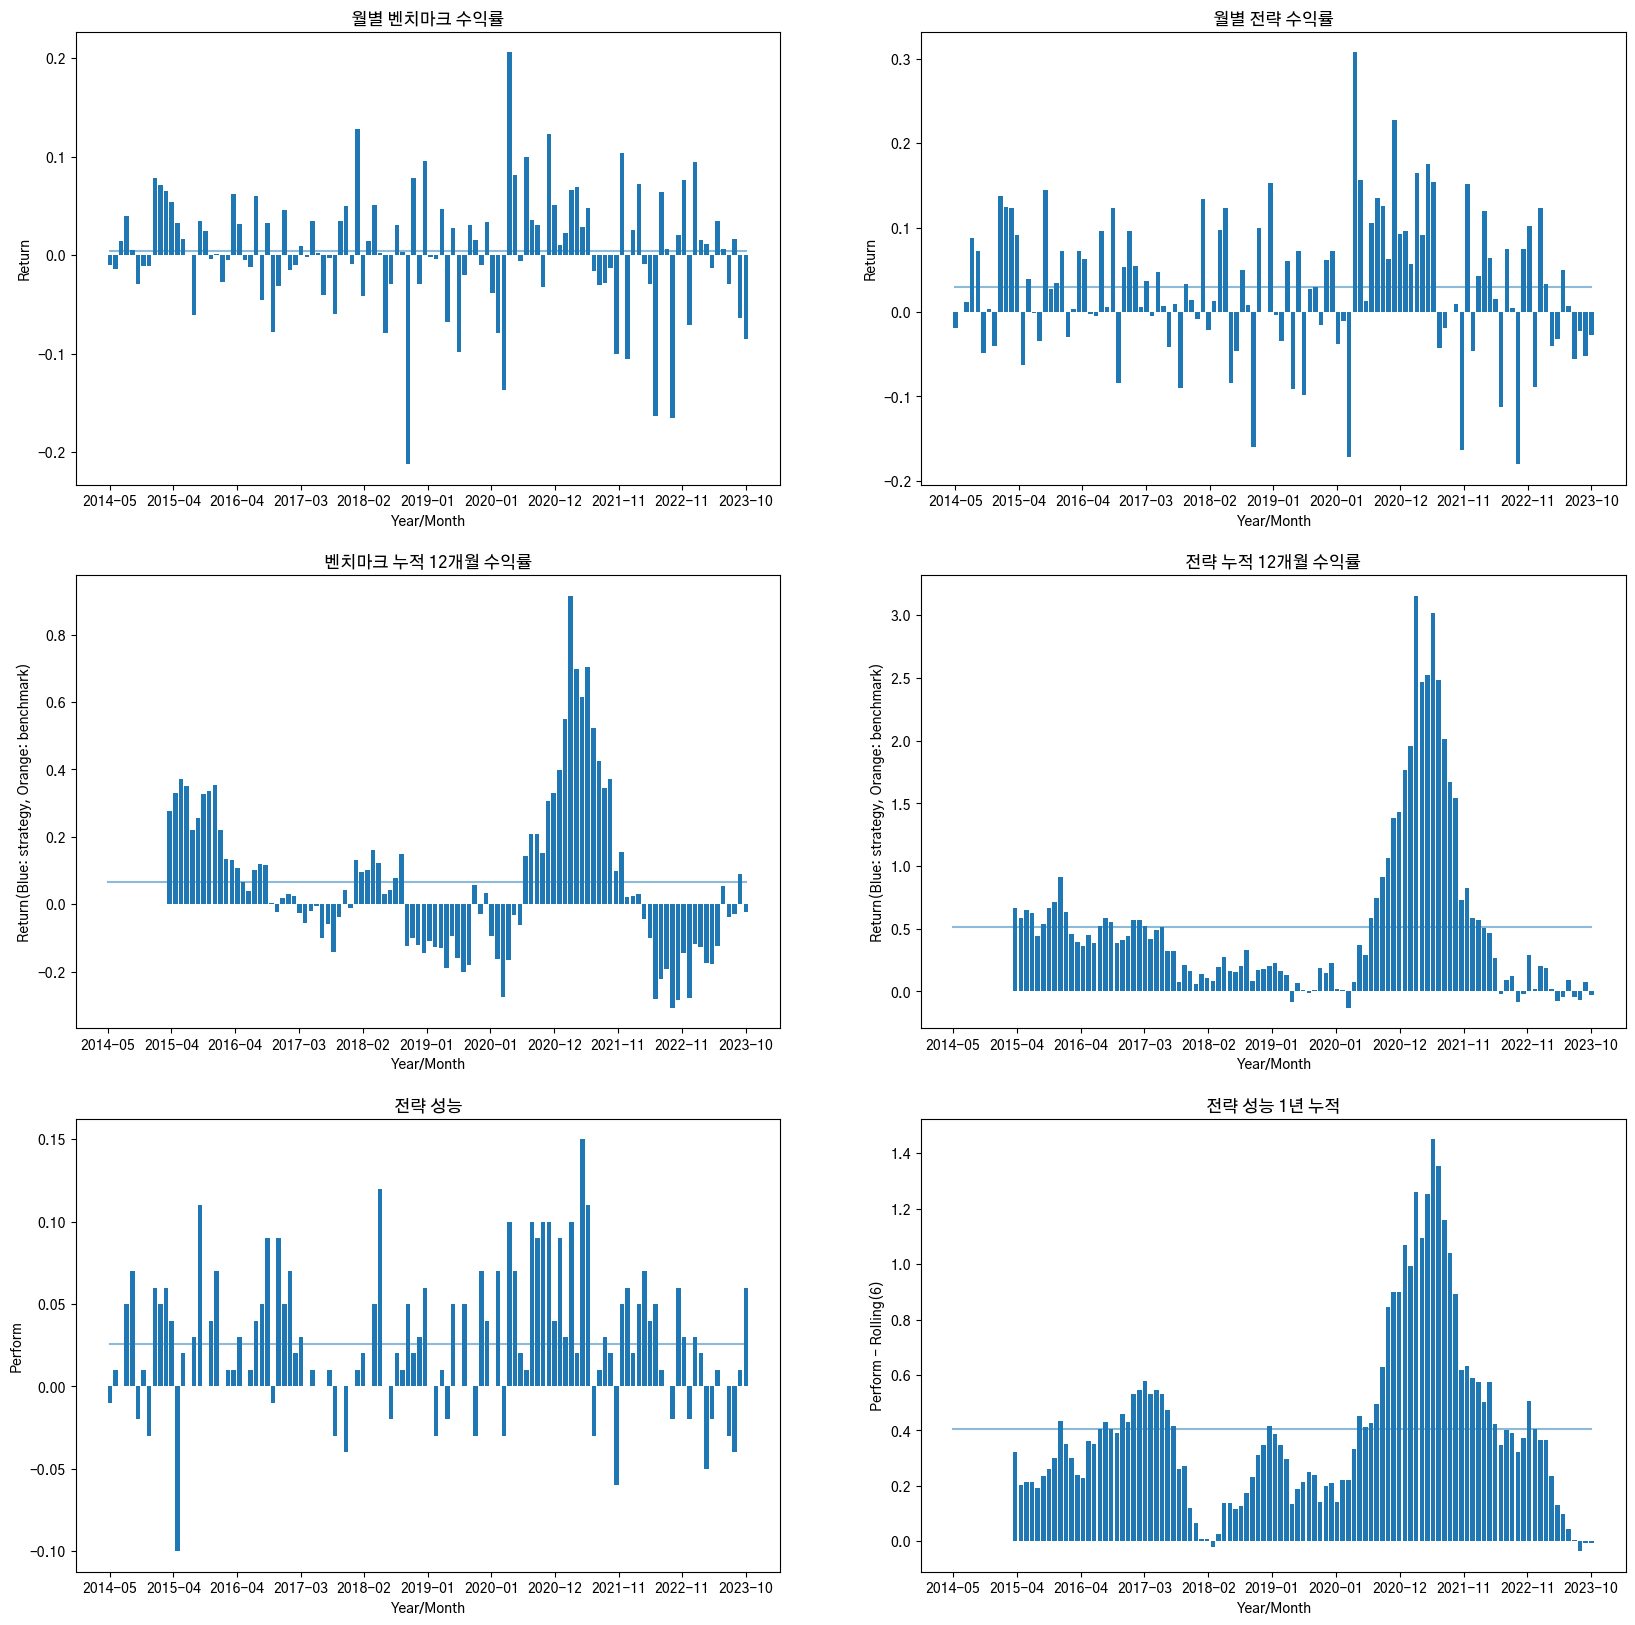

In [94]:
import numpy as np

months = [str(i) for _, i in strategy.index]

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.set_figwidth(20)
fig.set_figheight(20)

xticks = [1 * i / 10 for i in range(10)] + [1]

ax1.set_title(f"월별 벤치마크 수익률")
ax1.set_xlabel("Year/Month")
ax1.set_ylabel("Return")
ax1.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax1.bar(months, revisions["벤치마크 수익률"])
ax1.plot(months, [revisions["벤치마크 수익률"].mean()] * len(months), alpha=0.5)

ax2.set_title("월별 전략 수익률")
ax2.set_xlabel("Year/Month")
ax2.set_ylabel("Return")
ax2.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax2.bar(months, revisions["전략 수익률"])
ax2.plot(months, [revisions["전략 수익률"].mean()] * len(months), alpha=0.5)

ax3.set_title(f"벤치마크 누적 12개월 수익률")
ax3.set_xlabel("Year/Month")
ax3.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax3.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["벤치마크 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax3.bar(months, values)
ax3.plot(months, [values.mean()] * len(months), alpha=0.5)

ax4.set_title("전략 누적 12개월 수익률")
ax4.set_xlabel("Year/Month")
ax4.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax4.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["전략 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax4.bar(months, values)
ax4.plot(months, [values.mean()] * len(months), alpha=0.5)

ax5.set_title("전략 성능")
ax5.set_xlabel("Year/Month"), ax5.set_ylabel("Perform")
ax5.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax5.bar(months, revisions["성능"])
ax5.plot(months, [revisions["성능"].mean()] * len(months), alpha=0.5)

ax6.set_title(f"전략 성능 1년 누적")
ax6.set_xlabel("Year/Month")
ax6.set_ylabel(f"Perform - Rolling({6})")
ax6.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["성능"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax6.bar(months, values)
ax6.plot(months, [values.mean()] * len(months), alpha=0.5)

pd.Series({
    "total": len(revisions),
    "out-perform": len(revisions[revisions["성능"] > 0]),
    "승률": len(revisions[revisions["성능"] > 0]) / len(revisions),
    "누적 성능": (revisions["성능"] + 1).prod() - 1,
})